In [1]:
import numpy as np
import astropy.io.fits
import random
import os
import os.path
from collections import Counter
from PIL import Image
from sklearn.cluster import KMeans
from astropy.time import Time
import csv
from statistics import stdev
from statistics import mean
import math
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import cudf
from cuml.cluster import DBSCAN
from cuml.cluster import KMeans as cudkmean
import timeit

# Normalizing between [1,-1]
def normal(a):
    
    aa = a - a.min()
    bb = a.max() - a.min()
    cc = (2 * aa) / bb
    dd = cc - 1
    return dd


# Unnormal

def unnormal(norm, pure):
    ee = norm + 1
    ff = ee/2
    gg = ff * (pure.max() - pure.min())
    hh = gg + pure.min()
    return hh


# Getting Features

def getFeatures(Name):
    fileData = astropy.io.fits.open(Name)
    B = fileData[1].data
    B = np.array(B, dtype=np.float32)
    Binc = fileData[2].data
    Binc = np.array(Binc, dtype=np.float32)
    Bazi = fileData[3].data
    Bazi = np.array(Bazi, dtype=np.float32)
    DopF = fileData[4].data
    DopF = np.array(DopF, dtype=np.float32)
    #DopS = fileData[5].data
    #DopS = np.array(DopS, dtype=np.float64)
    SLFF = fileData[12].data
    SLFF = np.array(SLFF, dtype=np.float32)
    CI = fileData[32].data
    CI = np.array(CI, dtype=np.float32)


    return B, Binc, Bazi, DopF, SLFF, CI


# Removing that effect due to doppler shifts

def canNoise(Doppler):
    
    y = np.mean(Doppler, 0)
    x = np.array(range(Doppler.shape[1]))
    m, b = np.polyfit(x, y, 1)
    v = m*x + b
    out = Doppler - v

    return out

# Normalizing angles

def normangle(feature):
    
    
    a = np.cos(np.deg2rad(feature))
    
    return a
      

# Making a list for dimensions of observations
def dimlist(filenames):
    
    dimList = list()


    for i in NewList:

        file = astropy.io.fits.open(i)
        x, y = file[1].data.shape
        dimList.append((x, y))
    
    return dimList


# Concatenating all the observations

def concatfeatures(NewList):

    Btot, Binctot, DopFtot, SLFFtot, CItot = np.array([]), np.array([]),np.array([]), np.array([]),np.array([])



    for j in NewList:

        B, Binc, Bazi, DopF, SLFF, CI = getFeatures(j)
        Btot = np.concatenate((Btot, B), axis=None)
        Binctot = np.concatenate((Binctot, Binc), axis=None)
        DopFtot = np.concatenate((DopFtot, canNoise(DopF)), axis=None)
        SLFFtot = np.concatenate((SLFFtot, SLFF), axis=None)
        CItot = np.concatenate((CItot, CI), axis=None)
    
    
    return Btot, Binctot, DopFtot, SLFFtot, CItot

#Concateraw
def conpure(NewList):

    Btot, DopFtot, SLFFtot, CItot = np.array([]),np.array([]), np.array([]),np.array([])

    for j in NewList:

        B, Binc, Bazi, DopF, SLFF, CI = getFeatures(j)
        Btot = np.concatenate((Btot, B), axis=None)
        DopFtot = np.concatenate((DopFtot, DopF), axis=None)
        SLFFtot = np.concatenate((SLFFtot, SLFF), axis=None)
        CItot = np.concatenate((CItot, CI), axis=None)
    
    
    return Btot, DopFtot, SLFFtot, CItot


# Plot mappings
def pltmaps(labels, dimList, k):
    
    start = 0
    end = 0

    for s, tple in enumerate(dimList):

        end += tple[0] * tple[1]

        pltimg(labels[start:end], tple, s)

        start = end 
        
def pltimg(labels, tple, s):
    
    fileData = (NewList[s])
    v = fileData[42:-5]
    labless = labels.reshape(tple)
    plt.figure(figsize=(16,9))
    plt.imshow(labless, cmap="viridis", origin="bottom")
    plt.colorbar()
    plt.savefig(dir+'/'+ v + '.png')

    
    

    
    
NorthDir='/glade/work/egeland/hinode_synoptic/north'
allfiles = [os.path.join(NorthDir, f) for f in sorted(os.listdir(NorthDir))]

# Removing all sav files
NewList=[item for i,item in enumerate(allfiles) if i%2==0]
b = []

for item in NewList:
    
    fileData = astropy.io.fits.open(item)
    a = fileData[0].header['YSCALE']
    if a > 0.16 :
        b.append(item)

NewList = []       
NewList = b

In [4]:
def confe(NewList):

    Btot, Binctot, DopFtot, SLFFtot, CItot = np.array([]), np.array([]),np.array([]), np.array([]),np.array([])



    for j in NewList:

        B, Binc, Bazi, DopF, SLFF, CI = getFeatures(j)
        x, y = B.shape
        yy = random.randint(0, y-151)
        xx = random.randint(0, x-151)
        
        BB = B[xx:xx+150, yy:yy+150]
        
        BBinc = Binc[xx:xx+150, yy:yy+150]
        
        DopFF = canNoise(DopF)
        DDopF = DopFF[xx:xx+150, yy:yy+150]
        
        FF = SLFF[xx:xx+150, yy:yy+150]
        
        CCI = CI[xx:xx+150, yy:yy+150]

        Btot = np.concatenate((Btot, BB), axis=None)
        Binctot = np.concatenate((Binctot, BBinc), axis=None)
        DopFtot = np.concatenate((DopFtot, DDopF), axis=None)
        SLFFtot = np.concatenate((SLFFtot, FF), axis=None)
        CItot = np.concatenate((CItot, CCI), axis=None)
    
    
    return Btot, Binctot, DopFtot, SLFFtot, CItot

Btot, Binctot, DopFtot, SLFFtot, CItot = confe(NewList)


for it, item in enumerate(Btot):
    
    if item < 200:
        
        Btot[it] = 0
        Binctot[it] = 90
        SLFFtot[it] = 0
        
    elif item > 2000:
        
        Btot[it] = 2000
        

Btotn = normal(Btot)
Binctotn = normangle(Binctot)
DopFtotn = normal(DopFtot)
SLFFtotn = normal(SLFFtot)
CItotn = normal(CItot)

da = np.array([Btotn, Binctotn, DopFtotn, SLFFtotn, CItotn])
fda = np.transpose(da)

In [5]:
print(fda.shape)
cudf.set_allocator("managed")
X_df = pd.DataFrame({'fea%d'%i: fda[:, i] for i in range(fda.shape[1])})
X_gpu = cudf.DataFrame.from_pandas(X_df)

(1057500, 5)


In [6]:
kk = np.array(range(2,151, 5))
inlist = np.array([])
for k in kk:

    start = timeit.default_timer()

    cud = cudkmean(n_clusters = k)
    cud.fit(X_gpu)
    inert = cud.score(X_gpu)
    inlist = np.append(inlist, inert)
    stop = timeit.default_timer()

    print('Time: ', stop - start) 

Time:  0.6625460569921415
Time:  0.14101982201100327
Time:  0.13779906500712968
Time:  0.24456311701214872
Time:  0.23960669300868176
Time:  0.4774460500048008
Time:  0.3605811030138284
Time:  0.47000803699484095
Time:  0.6177486900123768
Time:  0.4843147420033347
Time:  0.5363695590058342
Time:  0.6458174079889432
Time:  0.6209710609982722
Time:  0.6678162159805652
Time:  1.0687934039742686
Time:  0.8960254470002837
Time:  0.736361631017644
Time:  0.847834319982212
Time:  1.3763318140117917
Time:  1.1973006979969796
Time:  1.7265338689903729
Time:  1.2558904390025418
Time:  1.837498651992064
Time:  1.555456681002397
Time:  1.9425248419865966
Time:  1.2688064229732845
Time:  2.014992255019024
Time:  1.983925006003119
Time:  1.7227885839820374
Time:  2.4937613160000183


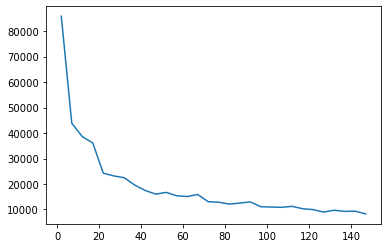

In [7]:
plt.plot(kk, np.abs(inlist))
plt.show()


In [8]:
'''
b = []

for item in NewList:
    
    fileData = astropy.io.fits.open(item)
    a = fileData[0].header['YSCALE']
    if a > 0.16 :
        b.append(item)

NewList = []       
NewList = b
'''
dimList = dimlist(NewList)

Btot, Binctot, DopFtot, SLFFtot, CItot = concatfeatures(NewList)

for it, item in enumerate(Btot):
    
    if item < 200:
        
        Btot[it] = 0
        Binctot[it] = 90
        SLFFtot[it] = 0
        
    elif item > 2000:
        
        Btot[it] = 2000
        
        

# Normalizing Features
Btotn = normal(Btot)
Binctotn = normangle(Binctot)
DopFtotn = normal(DopFtot)
SLFFtotn = normal(SLFFtot)
CItotn = normal(CItot)

da = np.array([Btotn, Binctotn, DopFtotn, SLFFtotn, CItotn])
fda = np.transpose(da)

In [9]:
print(fda.shape)
cudf.set_allocator("managed")
X_df = pd.DataFrame({'fea%d'%i: fda[:, i] for i in range(fda.shape[1])})
X_gpu = cudf.DataFrame.from_pandas(X_df)

(22620160, 5)


In [10]:
kk = np.array(range(2,151,5))
inlist = np.array([])
for k in kk:

    start = timeit.default_timer()

    cud = cudkmean(n_clusters = k)
    cud.fit(X_gpu)
    inert = cud.score(X_gpu)
    inlist = np.append(inlist, inert)
    stop = timeit.default_timer()

    print('Time: ', stop - start) 

Time:  1.465702766989125
Time:  2.1457774369919207
Time:  4.087013845972251
Time:  3.039745219022734
Time:  5.626181633997476
Time:  5.296133115974953
Time:  5.959345231996849
Time:  10.790861033980036
Time:  8.58681452300516
Time:  7.954684108000947
Time:  8.23137446999317
Time:  11.221193923993269
Time:  11.687541633000365
Time:  18.747303045995068
Time:  16.99861641100142
Time:  26.09733009999036
Time:  24.52871418200084
Time:  13.657401903998107
Time:  18.478931762976572
Time:  22.38240594501258
Time:  19.497040956979617
Time:  21.73880359798204
Time:  25.47247453298769
Time:  23.35492264200002
Time:  25.660348631994566
Time:  26.866451335023157
Time:  27.833242199994856
Time:  30.709430863003945
Time:  58.91793671800406
Time:  47.890501265996136


In [46]:
print(inlists)

[-1311391.10696058  -836362.30634143  -533211.59586583  -413755.71856406
  -380490.07242532  -439519.31185133  -346471.93689681  -335222.31213924
  -284223.11267757  -250261.87189531]


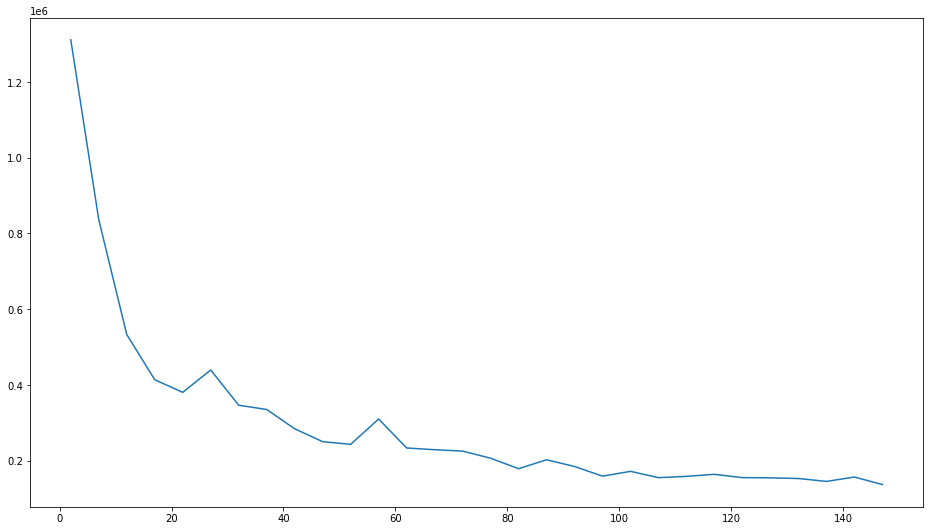

<Figure size 432x288 with 0 Axes>

In [13]:
plt.figure(figsize=(16,9))
plt.plot(kk, np.abs(inlist))
plt.show()
plt.savefig('ehe.png')

In [12]:
plt.savefig( 'ehe.png')


<Figure size 432x288 with 0 Axes>